<a href="https://colab.research.google.com/github/mohsinposts/Machine-Learning-Collection/blob/main/Iris.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from sklearn import datasets
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [ ]:
input_size = 4
hidden_size = 250
num_classes = 3
batch_size = 8
learning_rate = 1e-3
num_epochs = 100

In [ ]:
# create train and test data from iris dataset
X, y = datasets.load_iris(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# convert data to tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_test = torch.tensor(y_test, dtype=torch.long)

# create dataloader for data
train_data = TensorDataset(X_train, y_train)
test_data = TensorDataset(X_test, y_test)
train_dataloader = DataLoader(train_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super().__init__()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, num_classes),
        )

    def forward(self, x):
        logits = self.linear_relu_stack(x)
        return logits

In [ ]:
model = NeuralNetwork(input_size, hidden_size, num_classes).to(device)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    total_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X = X.to(device)
        y = y.to(device)

        # Compute prediction and loss
        pred = model(X)
        batch_loss = loss_fn(pred, y)

        # Backpropagation
        batch_loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 1 == 0:
            batch_loss, current = batch_loss.item(), (batch + 1) * len(X)
            print(f"Progress:[{current:>5d}/{dataset_size:>5d}]  batch loss:{batch_loss:>8f}")

        total_loss += batch_loss

    average_loss = total_loss / num_batches
    print(f"Train Error: Avg loss: {average_loss:>8f}")
    return average_loss


def test_loop(dataloader, model, loss_fn):
    model.eval()

    dataset_size = len(dataloader.dataset)
    num_batches = len(dataloader)
    test_loss, correct = 0, 0

    with torch.no_grad():
        for X, y in dataloader:
            X = X.to(device)
            y = y.to(device)

            # Get model pred
            pred = model(X)

            # Compute loss and
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    correct /= dataset_size

    print(f"Test Error: Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f}\n")
    return test_loss

In [ ]:
train_losses = []
test_losses = []

for t in range(num_epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    test_loss = test_loop(test_dataloader, model, loss_fn)
    train_losses.append(train_loss.detach().cpu())
    test_losses.append(test_loss)

print("Done!")

Epoch 1
-------------------------------
Progress:[    8/  120]  batch loss:1.074349
Progress:[   16/  120]  batch loss:0.895170
Progress:[   24/  120]  batch loss:1.475351
Progress:[   32/  120]  batch loss:0.870727
Progress:[   40/  120]  batch loss:0.818826
Progress:[   48/  120]  batch loss:0.808519
Progress:[   56/  120]  batch loss:0.863113
Progress:[   64/  120]  batch loss:0.789540
Progress:[   72/  120]  batch loss:0.681297
Progress:[   80/  120]  batch loss:0.670470
Progress:[   88/  120]  batch loss:0.692882
Progress:[   96/  120]  batch loss:0.886348
Progress:[  104/  120]  batch loss:0.598930
Progress:[  112/  120]  batch loss:0.678328
Progress:[  120/  120]  batch loss:0.602157
Train Error: Avg loss: 0.827067
Test Error: Accuracy: 96.7%, Avg loss: 0.564112

Epoch 2
-------------------------------
Progress:[    8/  120]  batch loss:0.402301
Progress:[   16/  120]  batch loss:0.431670
Progress:[   24/  120]  batch loss:0.634996
Progress:[   32/  120]  batch loss:0.441841
Pro

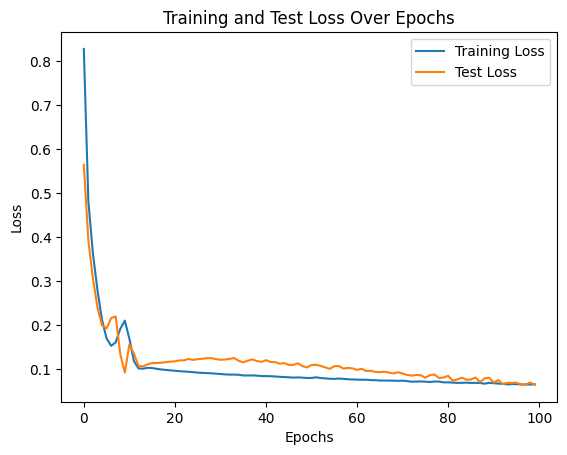

(<matplotlib.legend.Legend at 0x7ffa3eb7d2d0>, None)

In [ ]:
# plot training and test loss
plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Test Loss')
plt.xlabel('Epochs'), plt.ylabel('Loss'), plt.title('Training and Test Loss Over Epochs')
plt.legend(), plt.show()